In [1]:
import numpy as np
from scipy.special import gamma

import matplotlib.pyplot as plt

In [2]:
def linear_model(x, m, c):
    return m*x + c

### Generate data with Gaussian noise

\begin{align}
y = f(x) + n
\end{align}

Fetch some $\{y_i, x_i\}$. $n$ is a Gaussian.

In [3]:
injection_parameters = dict(m=0.8, c=2)

In [4]:
num_points = 100
x = np.linspace(-4, 4, num_points)

In [5]:
sigma = 0.6

In [6]:
data = linear_model(x, **injection_parameters) + np.random.normal(0, sigma, x.size)

Text(0, 0.5, 'y')

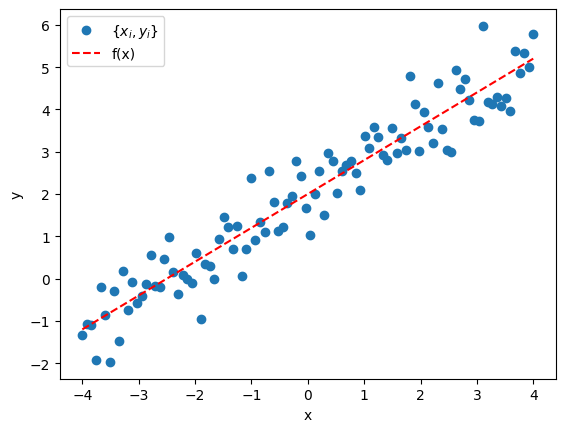

In [7]:
fig, ax = plt.subplots()
ax.plot(x, data, 'o', label='$\\{x_i, y_i\\}$')
ax.plot(x, linear_model(x, **injection_parameters), '--r', label='f(x)')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')

In [8]:
import bilby
from bilby.core.likelihood import GaussianLikelihood
from bilby.core.prior import Uniform, DeltaFunction

In [9]:
priors = dict()

priors['m'] = Uniform(-3, 3, name='m', latex_label='m')
priors['c'] = Uniform(-3, 3, name='c', latex_label='c')

In [10]:
log_l = GaussianLikelihood(x, data, linear_model, sigma=sigma)

In [ ]:
result = bilby.run_sampler(
    likelihood=log_l, priors=priors, sampler='dynesty',
    nlive=300, npool=4, save=False, clean=True,
    injection_parameters=injection_parameters,
    outdir='./linear_regression',
    label='linear_regression'
)

In [ ]:
result.plot_corner(priors=True, quantiles=(0.16, 0.84))

In [ ]:
print("Expected width of m = {:.2f}".format(sigma/np.sqrt(np.sum((x)**2))))

In [ ]:
print("Expected width of c = {:.2f}".format(sigma * np.sqrt(1/num_points)))

# Same problem by training a normalizing flow

In [11]:
from IPython.display import clear_output
from time import sleep

def live_plot_samples(samples, truth):
    clear_output(wait=True)
    sleep(1)
    figure = corner.corner(
        samples.numpy(), quantiles=[0.16, 0.5, 0.84],
        show_titles=True, labels=["m", "c"],
        truth=truth
    )

    corner.overplot_lines(figure, truth, color="C1")
    corner.overplot_points(figure, truth[None], marker="s", color="C1")


def live_plot_bilby_result(result, **kwargs):
    clear_output(wait=True)
    sleep(1)
    result.plot_corner(priors=True)

In [12]:
def get_data(m=None, c=None, num_points=1):
    """Sample m, c and return a batch of data with noise"""
    m = priors['m'].sample() if m is None else m
    c = priors['c'].sample() if c is None else c
    #x = 8 * (np.random.uniform(size=num_points) - 0.5)
    x = np.linspace(-4, 4, num_points)
    y = m*x + c
    y += sigma*np.random.normal(size=x.size)

    return x, y, m, c

# Generate simulations

In [13]:
from torch.utils.data import Dataset, DataLoader

In [14]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.tensorboard import SummaryWriter

In [15]:
num_simulations = 10000
theta_vals = []
data_vals = []
for ii in range(num_simulations):
    x_val, y_val, m_val, c_val = get_data(num_points=100)
    data_vals.append(y_val)
    theta_vals.append([m_val, c_val])

In [16]:
theta_vals = torch.from_numpy(np.array(theta_vals)).to(torch.float32)
data_vals = torch.from_numpy(np.array(data_vals)).to(torch.float32)

In [17]:
class DataGenerator(Dataset):
    def __len__(self):
        return num_simulations

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return theta_vals[idx], data_vals[idx]

In [18]:
dataset = DataGenerator()

In [19]:
train_set_size = int(0.8 * num_simulations)
val_set_size = int(0.1 * num_simulations)
test_set_size = int(0.1 * num_simulations)

train_data, val_data, test_data = torch.utils.data.random_split(
    dataset, [train_set_size, val_set_size, test_set_size])

In [20]:
train_data_loader = DataLoader(
    train_data, batch_size=20,
    shuffle=True
)

val_data_loader = DataLoader(
    val_data, batch_size=20,
    shuffle=True
)

test_data_loader = DataLoader(
    test_data, batch_size=1,
    shuffle=False
)

In [21]:
for theta, data in train_data_loader:
    break

In [22]:
theta.shape, data.shape

(torch.Size([20, 2]), torch.Size([20, 100]))

# MAF with std normal

In [23]:
import corner

from nflows.distributions import StandardNormal, ConditionalDiagonalNormal
from nflows.flows import Flow
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms import AffineTransform, CompositeTransform, ReversePermutation, RandomPermutation

from nflows.transforms import IdentityTransform

import nflows.utils as torchutils

In [65]:
num_transforms = 5
num_blocks = 2
hidden_features = 50

class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(100, 20),
            nn.ReLU(),
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.Linear(20, 8),
        )
    def forward(self, x):
        return self.net(x)

embedding_net = EmbeddingNet()

context_features = embedding_net(data[:1])[0].numel()

base_dist = ConditionalDiagonalNormal([theta[0].numel(), 2])

transforms = []

for _ in range(num_transforms):
    block = [
        MaskedAffineAutoregressiveTransform(
                features=4, #theta[0].numel(),  # 2-dim posterior
                hidden_features=hidden_features,
                context_features=context_features,
                num_blocks=num_blocks,
                activation=torch.tanh,
                use_batch_norm=False,
                use_residual_blocks=False,
        ),
        RandomPermutation(features=theta[0].numel())
    ]
    transforms += block

transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist, embedding_net)
# flow = Flow(transform, base_dist, embedding_net)

optimizer = optim.Adam(flow.parameters(), lr=1e-3)
# optimizer = optim.SGD(flow.parameters(), lr=1e-4, momentum=0.9)

scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

In [66]:
context_features, theta[0].numel()

(8, 2)

In [67]:
flow._embedding_net(data).shape

torch.Size([20, 8])

In [68]:
flow.log_prob(theta, context=data)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (20x2 and 4x50)

# Train/Validate

In [28]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for idx, val in enumerate(train_data_loader, 1):
        theta, data = val
        
        optimizer.zero_grad()
        loss = -flow.log_prob(theta, context=data).mean()
        loss.backward()
        optimizer.step()
        # Gather data and report
        running_loss += loss.item()
        if idx % 100 == 0:
            last_loss = running_loss / 100 # avg loss per batch after 1000 batches
            print(' Avg. train loss/batch after {} batches = {:.4f}'.format(idx, last_loss))
            tb_x = epoch_index * len(train_data_loader) + idx
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            tb_writer.flush()
            running_loss = 0.
    return last_loss../../libs/architectures/mlpe/architectures/flows/flow.py


def val_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for idx, val in enumerate(val_data_loader, 1):
        theta_val, data_val = val

        loss = -flow.log_prob(theta_val, context=data_val).mean()
        running_loss += loss.item()

        if idx % 50 == 0:
            last_loss = running_loss / 50
            tb_x = epoch_index * len(val_data_loader) + idx + 1
            tb_writer.add_scalar('Loss/val', last_loss, tb_x)
            tb_writer.flush()
            running_loss = 0.
    tb_writer.flush()
    return last_loss

In [29]:
flow

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=2, out_features=50, bias=True)
          (context_layer): Linear(in_features=4, out_features=50, bias=True)
          (blocks): ModuleList(
            (0): MaskedFeedforwardBlock(
              (linear): MaskedLinear(in_features=50, out_features=50, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (1): MaskedFeedforwardBlock(
              (linear): MaskedLinear(in_features=50, out_features=50, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=50, out_features=4, bias=True)
        )
      )
      (1): RandomPermutation()
      (2): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_

In [30]:
writer = SummaryWriter("linear_regression_again", comment="With LR=1e-4", flush_secs=5)
epoch_number = 0

In [31]:
EPOCHS = 100

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    # Gradient tracking
    flow.train(True)
    avg_train_loss = train_one_epoch(epoch_number, writer)
    
    # no gradient tracking, for validation
    flow.train(False)
    avg_val_loss = val_one_epoch(epoch_number, writer)
    
    print(f"Train/Val Loss after epoch: {avg_train_loss:.4f}/{avg_val_loss:.4f}")
    epoch_number += 1
    scheduler.step()

EPOCH 1:
 Avg. train loss/batch after 100 batches = 43.4071
 Avg. train loss/batch after 200 batches = 11.1752
 Avg. train loss/batch after 300 batches = -2.5520
 Avg. train loss/batch after 400 batches = -8.5410
Train/Val Loss after epoch: -8.5410/-17.0895
EPOCH 2:
 Avg. train loss/batch after 100 batches = -18.2918
 Avg. train loss/batch after 200 batches = -23.0590
 Avg. train loss/batch after 300 batches = -24.8025
 Avg. train loss/batch after 400 batches = -23.8844
Train/Val Loss after epoch: -23.8844/-35.8807
EPOCH 3:
 Avg. train loss/batch after 100 batches = -27.8060
 Avg. train loss/batch after 200 batches = -35.2146
 Avg. train loss/batch after 300 batches = -31.8527
 Avg. train loss/batch after 400 batches = -34.9929
Train/Val Loss after epoch: -34.9929/-41.4182
EPOCH 4:
 Avg. train loss/batch after 100 batches = -33.2551
 Avg. train loss/batch after 200 batches = -37.8414
 Avg. train loss/batch after 300 batches = -41.1895
 Avg. train loss/batch after 400 batches = -40.3240

 Avg. train loss/batch after 200 batches = -64.8572
 Avg. train loss/batch after 300 batches = -66.2543
 Avg. train loss/batch after 400 batches = -65.5952
Train/Val Loss after epoch: -65.5952/-61.1650
EPOCH 33:
 Avg. train loss/batch after 100 batches = -63.9174
 Avg. train loss/batch after 200 batches = -65.8903
 Avg. train loss/batch after 300 batches = -66.2566
 Avg. train loss/batch after 400 batches = -66.0246
Train/Val Loss after epoch: -66.0246/-59.3991
EPOCH 34:
 Avg. train loss/batch after 100 batches = -67.3510
 Avg. train loss/batch after 200 batches = -65.5118
 Avg. train loss/batch after 300 batches = -65.9646
 Avg. train loss/batch after 400 batches = -66.5667
Train/Val Loss after epoch: -66.5667/-67.6987
EPOCH 35:
 Avg. train loss/batch after 100 batches = -66.9493
 Avg. train loss/batch after 200 batches = -64.8528
 Avg. train loss/batch after 300 batches = -66.1389
 Avg. train loss/batch after 400 batches = -67.3394
Train/Val Loss after epoch: -67.3394/-67.4016
EPOCH 

 Avg. train loss/batch after 300 batches = -70.0392
 Avg. train loss/batch after 400 batches = -69.0871
Train/Val Loss after epoch: -69.0871/-67.1921
EPOCH 64:
 Avg. train loss/batch after 100 batches = -70.0855
 Avg. train loss/batch after 200 batches = -69.3822
 Avg. train loss/batch after 300 batches = -69.5697
 Avg. train loss/batch after 400 batches = -68.8129
Train/Val Loss after epoch: -68.8129/-64.7843
EPOCH 65:
 Avg. train loss/batch after 100 batches = -70.1681
 Avg. train loss/batch after 200 batches = -70.7973
 Avg. train loss/batch after 300 batches = -69.7165
 Avg. train loss/batch after 400 batches = -69.5866
Train/Val Loss after epoch: -69.5866/-62.8968
EPOCH 66:
 Avg. train loss/batch after 100 batches = -69.4000
 Avg. train loss/batch after 200 batches = -70.7932
 Avg. train loss/batch after 300 batches = -68.0046
 Avg. train loss/batch after 400 batches = -69.4856
Train/Val Loss after epoch: -69.4856/-67.8936
EPOCH 67:
 Avg. train loss/batch after 100 batches = -70.9

KeyboardInterrupt: 

# Check on test data

In [32]:
import pandas as pd

def cast_as_bilby_result(samples, truth):
    injections = dict.fromkeys(injection_parameters)
    injections['m'] = float(truth.numpy()[0])
    injections['c'] = float(truth.numpy()[1])

    posterior = dict.fromkeys(injection_parameters)
    samples_numpy = samples.numpy()
    posterior['m'] = samples_numpy.T[0].flatten()
    posterior['c'] = samples_numpy.T[1].flatten()
    posterior = pd.DataFrame(posterior)
    
    return bilby.result.Result(
        label="test_data",
        injection_parameters=injections,
        posterior=posterior,
        search_parameter_keys=list(injections.keys()),
        priors=priors
    )

In [33]:
for idx, (theta_test, data_test) in enumerate(test_data):
    if idx == 20: break 
    with torch.no_grad():
        samples = flow.sample(5000, context=data_test.reshape((1, 100)))
    live_plot_samples(samples[0], theta_test)
    plt.show()

KeyboardInterrupt: 

In [ ]:
samples.shape

# PP plot

In [34]:
results = []
for idx, (theta_test, data_test) in enumerate(test_data):
    with torch.no_grad():
        samples = flow.sample(5000, context=data_test.reshape((1, 100)))
    results.append(
        cast_as_bilby_result(samples[0], theta_test))

15:53 bilby INFO    : Key: KS-test p-value
15:53 bilby INFO    : m: 2.2945723727888708e-17
15:53 bilby INFO    : c: 8.576875762113707e-06
15:53 bilby INFO    : Combined p-value: 1.003296634731765e-20


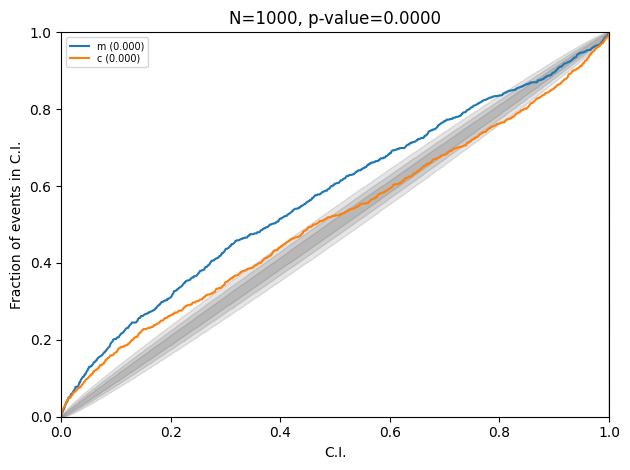

In [35]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bilby.result.make_pp_plot(results, save=False, keys=['m', 'c'])